In [1]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
if colab:
    import os
    os.chdir('/content/drive/My Drive/P3')

# Watch out for unexpected movie recommendations !

# Introduction

Our primary goal is to enhance content-based recommendations by uncovering hidden topics within movie plots using Latent Dirichlet Allocation (LDA). By identifying these latent themes, we can move beyond conventional genre-based recommendations to suggest movies with deeper, thematic similarities.

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Analysis</p>
    <div style="padding: 0 0 2px 10px;">
    
**What will be covered :**
- **Part 1 :** Data Pre-processing (covered in data_preprocessing.ipynb)
- **Part 2 :** Data exploration
- **Part 3 :** Latent Dirichlet Allocation (LDA)
- **Part 4 :** Are topics linked to genres/labels?
- **Part 5 :** Recommendation!!!
- **Part 6 :** Do topics capture enough similarity?
- **Part 7 :** Additional features Analysis

</div></div>
<br/>

---

### Import libraries

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import Counter
from src.utils.helpers import *
import pickle
import plotly.express as px
from imdb import IMDb
import re
from gensim.models import LdaModel
# Worcloud
from ipywidgets import interact, widgets

# Linear Regression 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# LDA visualisation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# PCA
from sklearn.decomposition import PCA

# DO WE ADD THE PREPROCESSING TO THIS NOTEBOOK? LIKE MAKE IT RUN OR MAKE A FUNCTION?

# Part 2: Data Exploration

*Comment: Part 1 with all the preprocessing of the dataset can be found in data_preprocessing.ipynb*

With the preprocessing done, we remain with 2 clean dataframes:
| Dataframe        | Description                                                                      | Number of movies |
|------------------|----------------------------------------------------------------------------------|------------------|
| LDA_df           | contains only movies (rows) with no NaN values in the movie genres column        | 14604            |
| features_df      | contains only movies (rows) with no NaN values in any column                     | 5904             |



Let's now explore some of their characteristics

### Part 2.1 Movies' summaries exploration

In [4]:
# Load LDA_df
LDA_df = pd.read_csv('Data/LDA_df.csv') #Import our dataframe

# Lengths of each plot synopsis
summary_lengths = LDA_df['plot_synopsis'].apply(len)

# Stats of plot synopsis length
LDA_df['plot_synopsis'].apply(lambda x: len(x)).describe().round()

count    14604.0
mean      5427.0
std       5028.0
min        656.0
25%       2616.0
50%       4000.0
75%       6169.0
max      63959.0
Name: plot_synopsis, dtype: float64

Comment
There is a difference between the mean and the median. Let's have a look at the distribution

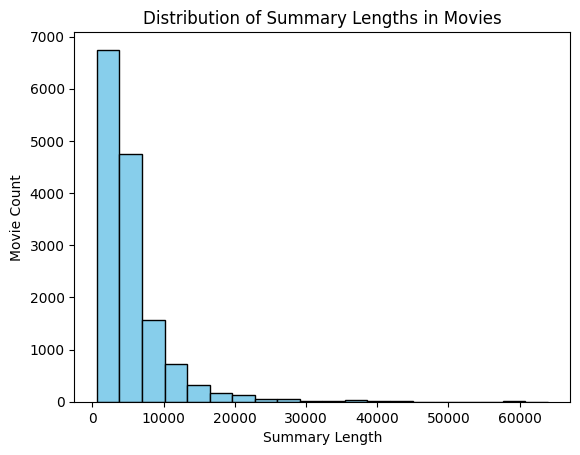

In [5]:
# Plot the histogram
plt.hist(summary_lengths, bins=20, color='skyblue', edgecolor='black')
plt.ylabel('Movie Count')  # y-axis will be the count of movies
plt.xlabel('Summary Length')  # x-axis will be the length of the summaries
plt.title('Distribution of Summary Lengths in Movies')
plt.show()

They are large differences in the summaries length. Since the distribution is a right-skewed distribution, as most summaries are short but a few are much longer.

### Part 2.2: Movies' genres exploration

Number of unique genres: 333


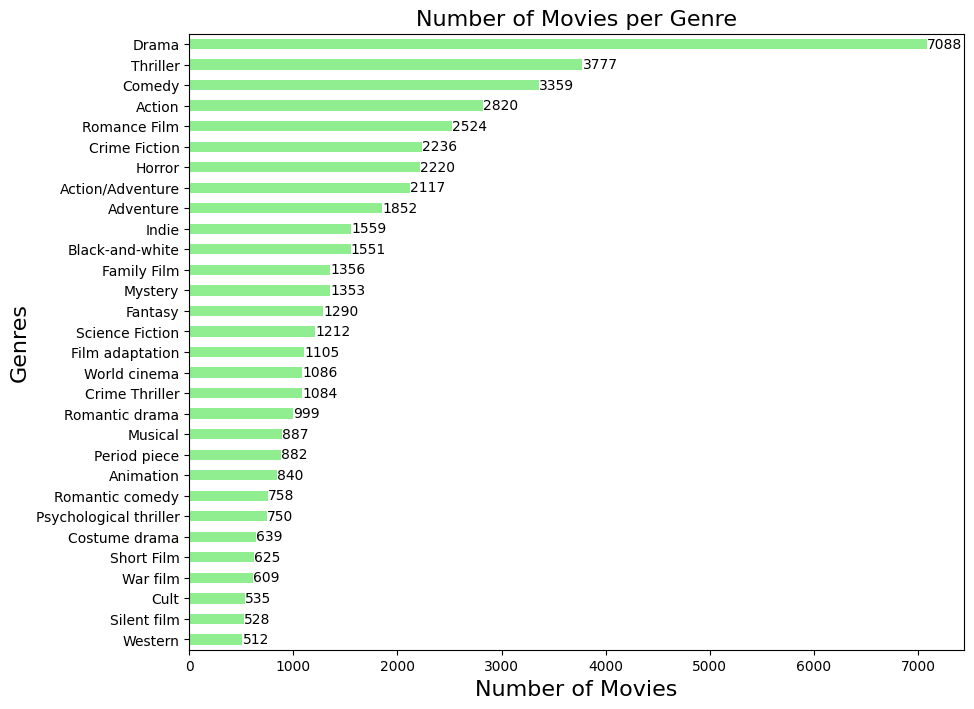

In [6]:
all_genres = LDA_df['Movie genres'].apply(ast.literal_eval).explode() # Changes elements from a list to a row

num_unique_genre = all_genres.nunique() # Creates list which each type of genre in all_genres
print("Number of unique genres:", num_unique_genre)

# Plot the number of movies per top 30 genres

genres_counts = all_genres.value_counts()

plt.figure(figsize=(10, 8))
bars = genres_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightgreen') # kind='barh' allows us to flip the axis
for index, value in enumerate(genres_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')
plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Genres', fontsize=16)
plt.title('Number of Movies per Genre', fontsize=16)
plt.show()

The data is concentrated in a few genres (`Drama`, `Thriller`, `Comedy`), with many genres having significantly fewer movies(`Western` or `Silent`). It is important to keep in mind that 1 movie can be assigned mutlitple genres which might explain why the genre `Drama` is such predominant in a lot of movie plots you have drama that is integrated to keep the movie entertaining and sentimental. In example if you have a `Western` movie it might include a murder or some kind of action such in the desert. 


*Here we decided to show only the top 30 genres to keep the chart clear and easy to read.*

### Part 2.3: What words describe which genre?
Let's look at what words appear most in movies genres. Can we already differentiate genres based on Word counts solely?

In [7]:
#generate_interactive_wordcloud(file=LDA_df, target1="Movie genres", target2="plot_synopsis", output_html="interactive_wordclouds.html", top_n=20)


From the word clouds across different genres, we observe that certain words, such as 'find,' 'tell,' 'one,' and 'see,' appear consistently across all genres. This is expected, as these are commonly used words. However, their large presence makes it difficult to discern clear trends or distinctions among the genres. Also different common names appear for different genres, like it is very probable to have ... in an ... movie. But in the end for specific genres such as Western or Gangster(*to verify once we ahve wordcloud*) we can already guess the genres that it corresponds to by looking at the word cloud only.

# Part 3: Latent Dirichlet Allocation (LDA)
LDA offers a way to cluster together movies that reflect similar themes, based on textual descriptions. The model does unsupervised learning, as the themes fo the movies are not known. To have more context we perform LDA on movies' synopses rather than movies' summaries which are longer and more descriptive. 

## 3.1 LDA Preprocessing
As observed in the word cloud, highly repetitive words that appear across all movies could influence our analysis by dominating the results. Additionally, we remove names to avoid relying on them in our analysis, just because the main character is named Joe doesn't necessarily mean the movie should be predicted as a `Western`.  

The preprocessing is handled and further discussed in `model_training.ipynb`.

## 3.2 Number of topics selection

The main parameter to give when it comes to LDA is the number of topics LDA will produce. To select the number of topics we use Word2Vec coherence score, quantifying how good are the topics formed by a LDA model.  Word2Vec is a NLP technique which consists in representing words with vectors that capture the meaning of the word. This means two words with similar meaning (i.e. prince and king) will be close in the vector space. For each LDA model, we can attribute a coherence score based on the intra/inter similarity between topics with the following formula :

$C_{sim} = \frac{1}{N-1}\sum_{i ≠ j}\frac{\frac{\text{intra(i)} + \text{intra(j)}}{2}}{\text{inter(i,j)}}$

with $N$ the number of topics, $\text{intra(i)}$ the average similarity between words of topic $i$ and $\text{inter(i, j)}$ the average similarity between words of topic $i$ and $j$.

The working principle is quite intuitive:
* Maximize intra-topic similarity: similarity of words in the same topic.

* Minimize inter-topic similarity: the similarity of words across different topics.

The function to get the similarity coherence score $C_{sim}$ is available in the `utils/helpers.py` file.

The whole coherence score analysis is available in `model_training.ipynb`.


*** TO PUT IN OTHER FILE: Gensim provides a function to get a coherence score called $C_v$ but after checking some documentation [check here](https://www.baeldung.com/cs/topic-modeling-coherence-score), we came to the conclusion that Gensim function wasn't very reliable. So we use own coherence score using the Word2Vec model.

### Run LDA for various number of topics 


In [8]:
# Load the dictionary
from gensim.corpora import Dictionary
dictionary = Dictionary.load("Data/dictionary.dict")

# Load the corpus
from gensim.corpora import MmCorpus
corpus = MmCorpus("Data/corpus.mm")

# Load coherence scores /topic
with open('Data/coherence_sim.pkl', "rb") as file:
    coherence_sim = pickle.load(file)

Let's see what number of topics has the best coherence. Note that we didn't go further than 19 topics in our exploration to keep the method and the analysis clear and concise. 

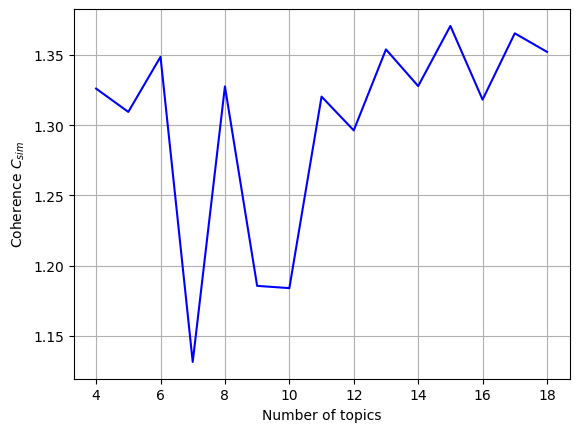

In [9]:
# Coherence Score per number of topics
topic_number = range(4, 19, 1)
plt.plot(topic_number, coherence_sim, 'b', label=r'$C_{sim}$')
plt.xlabel('Number of topics')
plt.ylabel(r'Coherence $C_{sim}$')
plt.grid()

The highest coherence score is at 15 topics. Which means that it is the number of topics for which the themes within a topic are most similar and the topics between them are most different. Thus, for the rest of the analysis we will classify our movies between those 15 topics

### Part 3.2: What topics did we recover?
Let's see first what's the word distribution for each topic is:

In [10]:
# Load model
lda_model = LdaModel.load("src/models/lda_model15.model")

# Display 8 most relevant word per topic
for topic_id, topic_words in lda_model.print_topics(num_words=8):
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.006*"police" + 0.006*"car" + 0.005*"murder" + 0.004*"killer" + 0.004*"shoot" + 0.004*"run" + 0.003*"reveal" + 0.003*"escape"
Topic 1: 0.005*"murder" + 0.005*"say" + 0.005*"woman" + 0.004*"ask" + 0.003*"case" + 0.003*"look" + 0.003*"work" + 0.003*"police"
Topic 2: 0.012*"say" + 0.008*"ask" + 0.008*"get" + 0.008*"room" + 0.007*"house" + 0.007*"look" + 0.007*"door" + 0.006*"run"
Topic 3: 0.004*"Beast" + 0.004*"barricade" + 0.004*"life" + 0.003*"escape" + 0.003*"Marius" + 0.003*"house" + 0.003*"daughter" + 0.003*"order"
Topic 4: 0.005*"game" + 0.005*"say" + 0.004*"team" + 0.004*"ask" + 0.004*"Lord_Blackwood" + 0.004*"Lord" + 0.003*"run" + 0.003*"room"
Topic 5: 0.007*"Macbeth" + 0.006*"king" + 0.005*"son" + 0.005*"King" + 0.004*"army" + 0.004*"prophecy" + 0.004*"castle" + 0.004*"order"
Topic 6: 0.009*"car" + 0.009*"say" + 0.007*"ask" + 0.007*"get" + 0.006*"police" + 0.006*"money" + 0.006*"gun" + 0.005*"shoot"
Topic 7: 0.020*"Sir" + 0.004*"musketeer" + 0.003*"ask" + 0.003*"uncle" 

From this list of words we observe that the preprocessing isn't perfect because some character names still remain as they were not recognize by the spacy analyzer. However we can still easily dicerner some topics. For example the topic 0 seems to describe crime movies, with keywords like police, murder, shoot and car. We asked the NLP AI Chat-GPT ([source](https://chatgpt.com)) to name each topic depending on its words distribution. Here are the names of each topic:

| Topic | Keywords                    | Theme                                  |
|-------|-----------------------------|----------------------------------------|
| 0     | police, car, murder         | Crime and Pursuit                      |
| 1     | murder, woman, case         | Investigative Drama                    |
| 2     | say, ask, room              | Domestic Suspense                      |
| 3     | Beast, barricade, escape    | Struggle and Sacrifice                 |
| 4     | game, team, treasure        | Adventure and Teamwork                 |
| 5     | Macbeth, king, prophecy     | Shakespearean Power Struggles          |
| 6     | car, police, money          | Urban Crime and Violence               |
| 7     | Sir, musketeer, airship     | Historical and Heroic Tales            |
| 8     | Lincoln, look, life         | Identity and Discovery                 |
| 9     | say, money, love            | Emotional Conflict and Drama           |
| 10    | house, vampire, family      | Supernatural and Gothic                |
| 11    | love, family, school        | Family and Everyday Life               |
| 12    | guard, musketeer, sword     | Adventure and Loyalty                  |
| 13    | say, look, castle           | Drama and Character Interaction        |
| 14    | escape, attack, team        | Action and Strategy                    |


Let's add to the dataframe the distribution of topics for each movie, and the main topic (the one with highest distribution).

In [11]:
### Change naem to LDA_final

In [12]:
movie_final = pd.read_csv('Data/LDA_df.csv') # Import LDA_df to further modify it

In [13]:
topic_distrib = [sorted(lda_model.get_document_topics(doc), key=lambda x: x[1], reverse=True) for doc in corpus]
movie_final.insert(loc=len(movie_final.columns), column='Topics', value=topic_distrib)
topic_dic = {
    0: 'Crime and Pursuit', 1: 'Investigative Drama', 2: 'Domestic Suspense', 3: 'Struggle and Sacrifice',
    4: 'Adventure and Teamwork', 5: 'Shakespearean Power Struggles', 6: 'Urban Crime and Violence',
    7: 'Historical and Heroic Tales', 8: 'Identity and Discovery', 9: 'Emotional Conflict and Drama',
    10: 'Supernatural and Gothic', 11: 'Family and Everyday Life', 12: 'Adventure and Loyalty',
    13: 'Drama and Character Interaction', 14: 'Action and Strategy',
}
movie_final['Main Topic'] = movie_final['Topics'].apply(lambda x : topic_dic[x[0][0]])
movie_final.head(3)

imdb_id                                     Movie name  \
0  tt1733125  Dungeons & Dragons: The Book of Vile Darkness   
1  tt0033045                     The Shop Around the Corner   
2  tt0113862                             Mr. Holland's Opus   

                                       plot_synopsis  \
0  Two thousand years ago, Nhagruul the Foul, a s...   
1  Matuschek's, a gift store in Budapest, is the ...   
2  Glenn Holland, not a morning person by anyone'...   

                                     tags  \
0                                violence   
1                                romantic   
2  inspiring, romantic, stupid, feel-good   

                                        Movie genres  averageRating  \
0                                        ['Fantasy']            4.4   
1  ['Romantic comedy', 'Workplace Comedy', 'Black...            8.0   
2  ['Inspirational Drama', 'Family Film', 'Drama'...            7.3   

                                              Topics                Main Topic  
0  [(10, 0.7467012), (14, 0.103723414), (5, 0.072...   Supernatural and Gothic  
1  [(11, 0.75163704), (1, 0.11554898), (6, 0.0902...  Family and Everyday Life  
2  [(11, 0.80156773), (9, 0.12116508), (2, 0.0624...  Family and Everyday Life

## 3.4 Topics analysis
What kind of topics did we get? Are there significantly different from each other?

### 3.3.2 Topics interpretation with pyLDAvis

In [14]:
# Common way of showing results from an LDA analysis

# Prepare pyLDAvis visualisation
lda_vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualisation
pyLDAvis.display(lda_vis_data)

/opt/jlab-env-3.12.5/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=138) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/jlab-env-3.12.5/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=138) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/jlab-env-3.12.5/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=138) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/jlab-env-3.12.5/lib/python3.12/site-packages/pytz/tzinfo.py:27: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _epoch = datet

The topics are ordered based on the percentage of tokens that were used to create them. By setting the relevance to 1 (λ=1), we can see how much each topic uses this word. Words like "army" appear in most topics. But in order to differentiate each other, the topics also have words specific to them that can be seen when setting the relevance to 0 (λ=0). We can then see that for Topic 7, "MacBeth" is an important word specific to this topic.
While only topics `Adventure and Loyalty`, `Identity and Discovery`, and `Family and Everyday Life` are isolated form the rest all other topics are still very different from each other but this is not evident since the 15 dimensions of the topics are projected to only 2 dimensions.

# Part 4: Are topics linked to genres/labels?
### Networks between topics
We begin with networks, where two topics have an edge if they have a genre in common. This is done starting with a bipartite graph between topics and genres. To link a topic with a genre, we check how often this genre appear for movies with the given topic. If this proportion is larger than a chosen threshold, we link the topic to the genre. 

## Part 4.1.1 : Which Topics Are Associated with Specific Genres?

In [15]:
## TO PUT IN HELPER.PY
def draw_bipartite(movie_df, topic_dic, threshold, mode='genres'):
    """
    Draws a bipartite graph between topics and genres, only including genres with connections.

    Parameters:
        movie_df (DataFrame): DataFrame containing movie data, including 'Movie genres' and 'Main Topic'.
        topic_dic (dict): Dictionary of topics.
        threshold (float): Threshold to determine connections.

    Returns:
        tuple: Average random probability and genre probability.
    """
    # Step 1: Prepare data
    df_copy = movie_df.copy()

    if mode == "genres":
        genre_array = df_copy['Movie genres'].apply(ast.literal_eval)
        plot_title = "Filtered Bipartite Graph: Topics and Connected Genres"
    elif mode == "tags":
        df_copy['tags'] = df_copy['tags'].apply(lambda x: [item.strip() for item in x.split(',')])
        genre_array = df_copy['tags']
        plot_title = "Filtered Bipartite Graph: Topics and Connected Tags"
    else:
        raise ValueError("Mode must be either 'genres' or 'tags'")

    df_copy['Movie genres'] = genre_array
    all_genres = genre_array.explode().tolist()
    genre_list = list(set(all_genres))
    topic_list = list(topic_dic.values())

    # Step 2: Build the bipartite graph
    B = nx.Graph()
    B.add_nodes_from(topic_list, bipartite=0)  # Topics
    B.add_nodes_from(genre_list, bipartite=1)  # Genres

    edges = []
    topic_occ = np.zeros(len(topic_list))

    # Step 3: Add edges based on threshold
    for i, topic in enumerate(topic_list):
        curr = df_copy[df_copy['Main Topic'] == topic]
        topic_occ[i] = len(curr)
        for genre in genre_list:
            genre_mean = np.mean(curr['Movie genres'].apply(lambda x: genre in x))
            if genre_mean > threshold:
                edges.append((topic, genre))

    B.add_edges_from(edges)

    # Step 4: Filter nodes to keep only connected genres
    connected_genres = {v for u, v in B.edges() if u in topic_list}
    connected_nodes = topic_list + list(connected_genres)
    B_filtered = B.subgraph(connected_nodes)

    # Step 5: Layout and visualization
    pos = nx.bipartite_layout(B_filtered, topic_list)
    plt.figure(figsize=(14, 14))

    # Node sizes and colors
    node_sizes = [800 if n in topic_list else 300 for n in B_filtered.nodes()]
    node_colors = ['lightgreen' if n in topic_list else 'lightblue' for n in B_filtered.nodes()]

    # Draw graph
    nx.draw(
        B_filtered, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',
        width=1.5,
        font_size=10
    )

    plt.title(plot_title)
    plt.show()

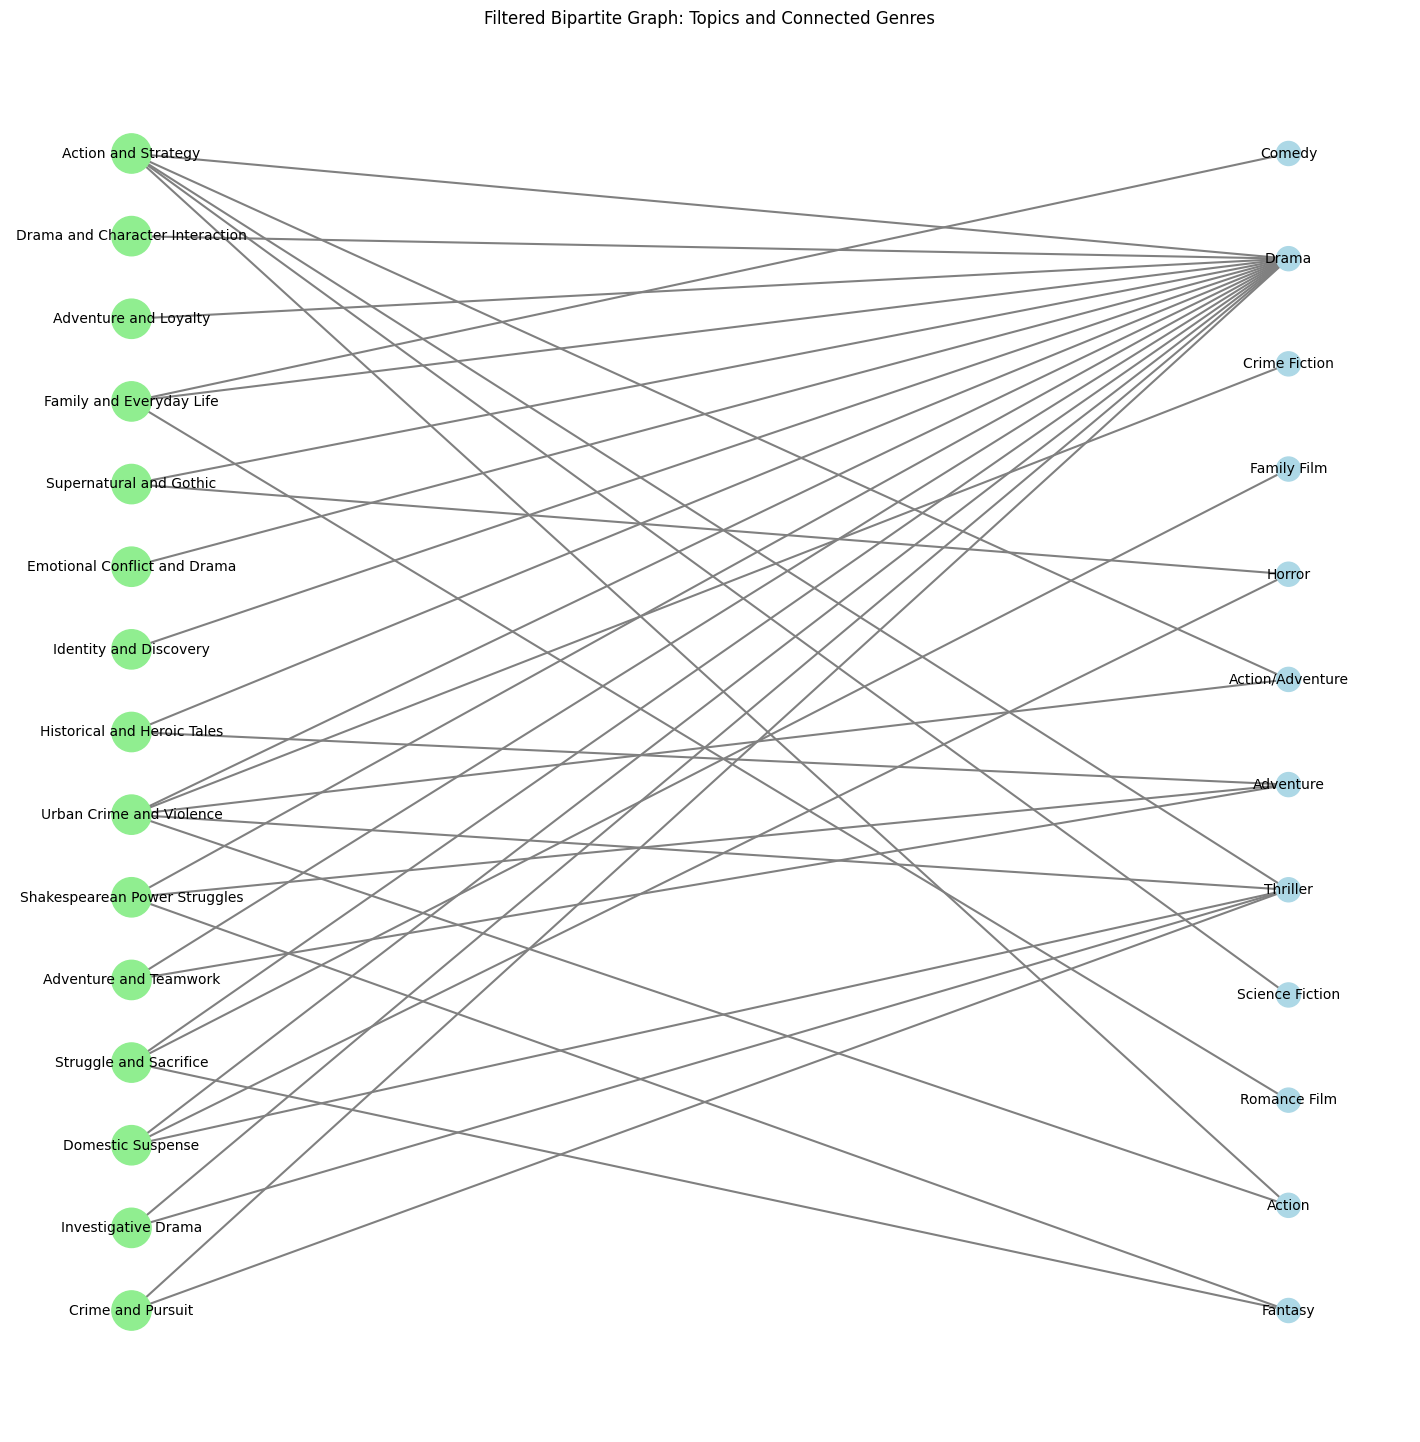

In [37]:
draw_bipartite(movie_final, topic_dic, threshold=0.29, mode='genres')

We see that most genres and topics do not appear since they are not linked . Among the linked categories, the `Drama` genre stands out, being represented by multiple subtopics. Conversely, some topics serve as aggregates of genres; for instance, `Urban Crime and Violence` can encompass subgenres such as `Thriller`, `Drama`, `Adventure` and `Crime Fiction`.

## Part 4.1.2: How are topics linked together based on genres similarity

To assess how similar topics are we can analyse how many genres connections they share. This is done by projecting the bipartite graph into a new graph where only topics are nodes, and the edges represent how many genres two topics share.

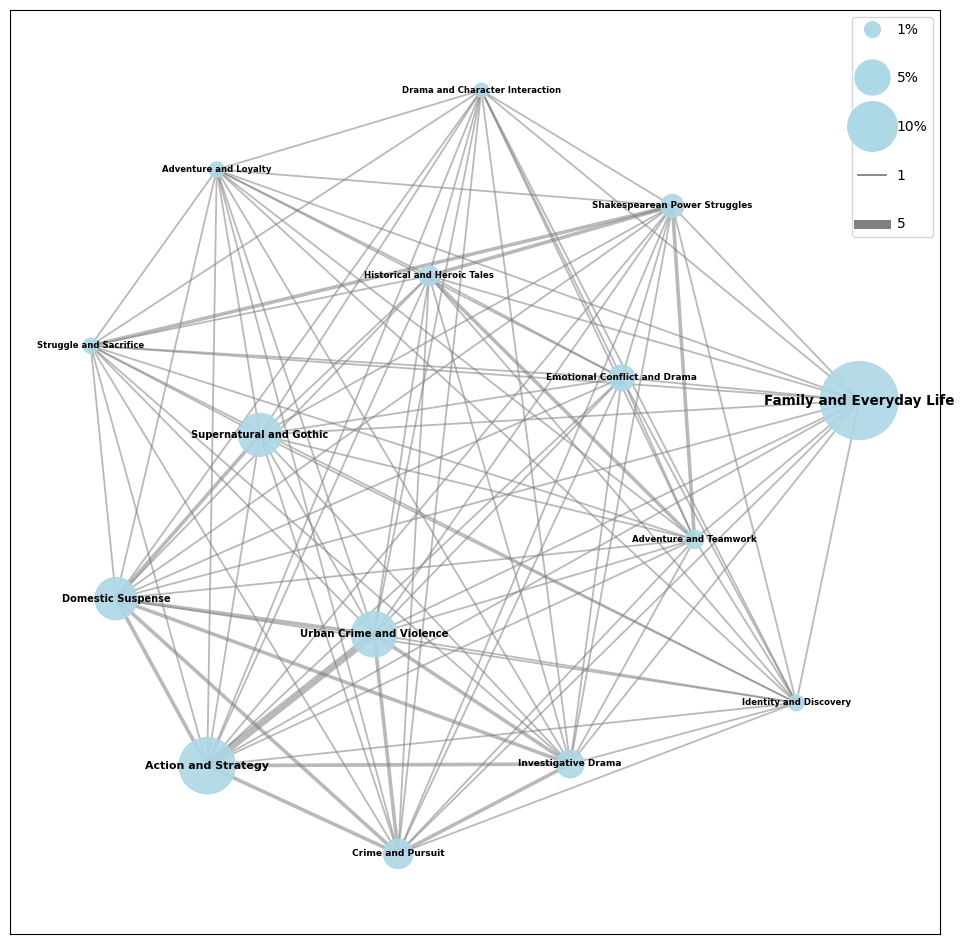

In [43]:
[link_probability_random, link_proportion] = draw_network_genre(movie_final, topic_dic, threshold=0.29)

We see that the `Family and Everyday Life` is the predominant main topic in our dataset. `Action and Strategy` and `Urban Crime and Violence` have the most genres in common.

### Part 4.1.3: Do topics reflect genres?

To assess if the genres are reflected by genres, we calculate the average probability of a random link between a topic and a genre. By comparing this random probability with the actual proportion of links in our graph, we can evaluate how well our topics are capturing the genres.

In [44]:
print(f'The probability of link if topics were independant of genres would be {round(link_probability_random*100,3)}%.')
print(f'The proportion of link between topics and genres is {round(link_proportion*100,3)}%.')

The probability of link if topics were independant of genres would be 0.004%.
The proportion of link between topics and genres is 1.289%.


We observe that we have way more links than if our genres were randomly distributed. This means that our topics reflects to some extend the genres!

## Part 4.2.1 : Which Topics Are Associated with Specific Tags?
Let's do the same analysis with the labels of the MPST dataset added earlier instead of genres.

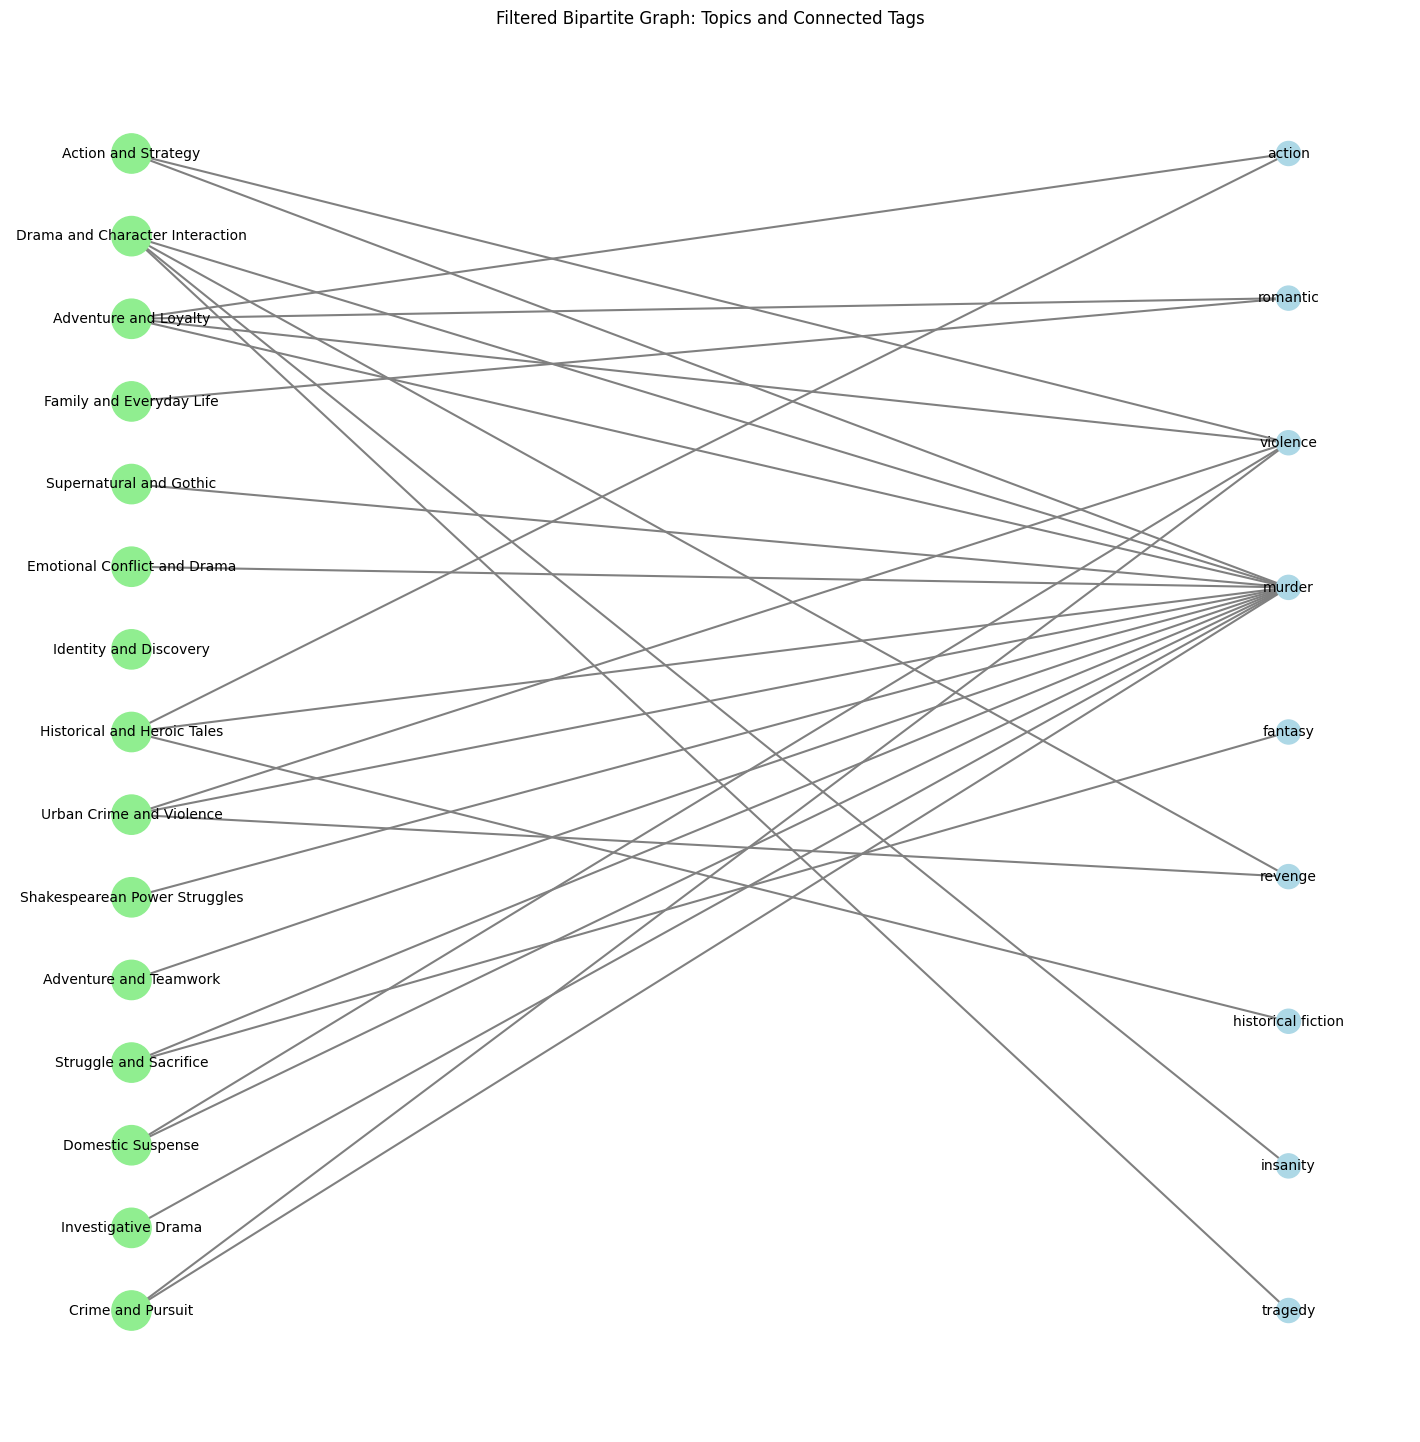

In [18]:
draw_bipartite(movie_final, topic_dic, threshold=0.29, mode='tags')

We see that most genres and topics do not appear since they are not linked . Among the linked categories, the `Murder` genre stands out, being represented by multiple subtopics. Conversely, some topics serve as aggregates of genres; for instance, `Historical and Heroic Tales` can encompass subgenres such as `Historical Fiction`, `Action`, and `Murder`.

## Part 4.2.2: How are topics linked together based on tags similarity

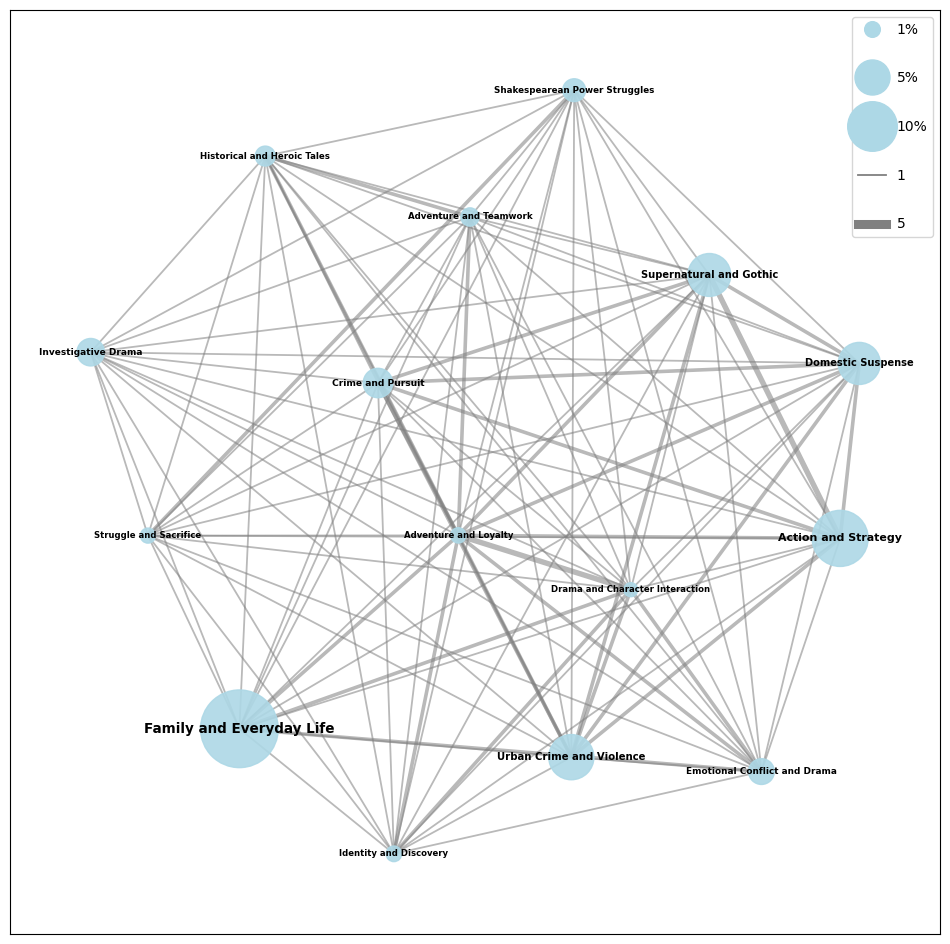

In [45]:
[link_probability_random, link_proportion] = draw_network_tags(movie_final, topic_dic, threshold=0.25)

We see that smaller topics share the most tags connections such as `Historical and Heroic Tales`, `Crime and Pursuit` and `Adventure and loyalty`.

## Part 4.2.3: Do topics reflect tags?

In [46]:
print(f'The probability of link in a random relation between topics and labels would be {round(link_probability_random*100,3)}%.')
print(f'The proportion of link between topics and labels is {round(link_proportion*100,3)}%.')

The probability of link in a random relation between topics and labels would be 4.29%.
The proportion of link between topics and labels is 4.29%.


The two percentages are surprisingly close. This means labels are statistically random for our topics. We thus can't infer any trends between topics and tags from this network.

# Part 5: Recommendations!!!

Now that we have discovered new information about a movie. Let's put it to use for movie recommendation. Give us a movies you like, you will get a new movie recommendation by picking the most similar movie (closest topics).

In [20]:
def format_topics(topics, num_topics=15):
    topic_dict = {topic: prob for topic, prob in topics}
    return [topic_dict.get(i, 0) for i in range(num_topics)]

# Convert to list
movie_final['Topics'] = movie_final['Topics'].apply(format_topics)

# Convert to array
movie_final['Topics'] = movie_final['Topics'].apply(np.array)

# Check results
print(movie_final['Topics'].head().value_counts())

Topics
[0.0, 0.0, 0.0, 0.0, 0.07204169034957886, 0.0724283754825592, 0.0, 0.0, 0.0, 0.0, 0.746701180934906, 0.0, 0.0, 0.0, 0.10372341424226761]                        1
[0.0, 0.1155489832162857, 0.04013889655470848, 0.0, 0.0, 0.0, 0.090211883187294, 0.0, 0.0, 0.0, 0.0, 0.7516370415687561, 0.0, 0.0, 0.0]                         1
[0.0, 0.0, 0.06243697181344032, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12116508185863495, 0.0, 0.8015677332878113, 0.0, 0.013975013047456741, 0.0]                     1
[0.056060466915369034, 0.050623293966054916, 0.0, 0.0, 0.0, 0.0, 0.6062086224555969, 0.0, 0.0, 0.0, 0.0, 0.17218396067619324, 0.0, 0.0, 0.10554035753011703]    1
[0.056074757128953934, 0.05076228454709053, 0.0, 0.0, 0.0, 0.0, 0.606146514415741, 0.0, 0.0, 0.0, 0.0, 0.17213024199008942, 0.0, 0.0, 0.1055135652422905]       1
Name: count, dtype: int64


All topics are well formatted let's now compute the most similar movie with a recommendation algorithm

In [21]:
def recommend_similar_movie(movie_name):

  # Check that movie name is in the dataframe
  if not (movie_final['Movie name'] == movie_name).any():
    return "Error: This Movie is either mispelled or not in the database."

  else:
    # From movie name get topic score
    movie_infos = movie_final[movie_final['Movie name'] == movie_name].iloc[0]
    other_movies = movie_final[~(movie_final['Movie name'] == movie_name)]

    # Euclidean distances
    distances = other_movies['Topics'].apply(
        lambda x: np.linalg.norm(x - movie_infos['Topics'])
    )

    closest_movie = distances.nsmallest(1).index[-1]
    return print("You should watch" , other_movies['Movie name'].iloc[closest_movie], "(imdb_id:", other_movies['imdb_id'].iloc[closest_movie],")" )

# Prompt the user for input
movie_name = input("Please enter a  movie name: ") # Scarface, Dungeons & Dragons: The Book of Vile Darkness

recommend_similar_movie(movie_name)


Please enter a  movie name:  Scarface


You should watch Intent to Kill (imdb_id: tt0107222 )


# Part 6: Similarity Analysis
### Are Topics enough for recommandation ?

We will first start by make the assumption that similar topics have similar ratings. In fact if we do not want to recommend movies based on the highest rating, if you liked a cheesy low-rated christmas movie you might not want to watch the highest Can prized movie next. We will first analyse if this statement is true for genres and then see if similar movies have similar ratings using dimensionality reduction analysis.

## Part 6.1: Are ratings similar accross genres?
First we will start by analyzing how the ratings change across genres. 

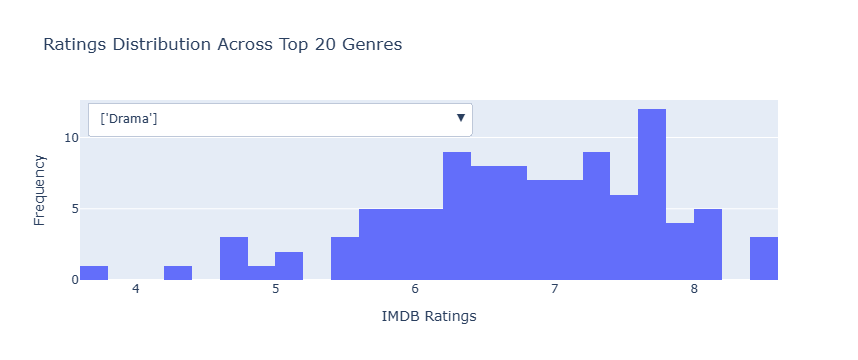

In [58]:
# Import dataset and format is
features_df = pd.read_csv('Data/features_df.csv')
features_df['Movie genres'] = features_df['Movie genres']

# Plot the ratings distribution across top genres
plot_ratings_dropdown(features_df, genre_column='Movie genres', rating_column='averageRating', top_n=20, output_html="ratings_dropdown.html")

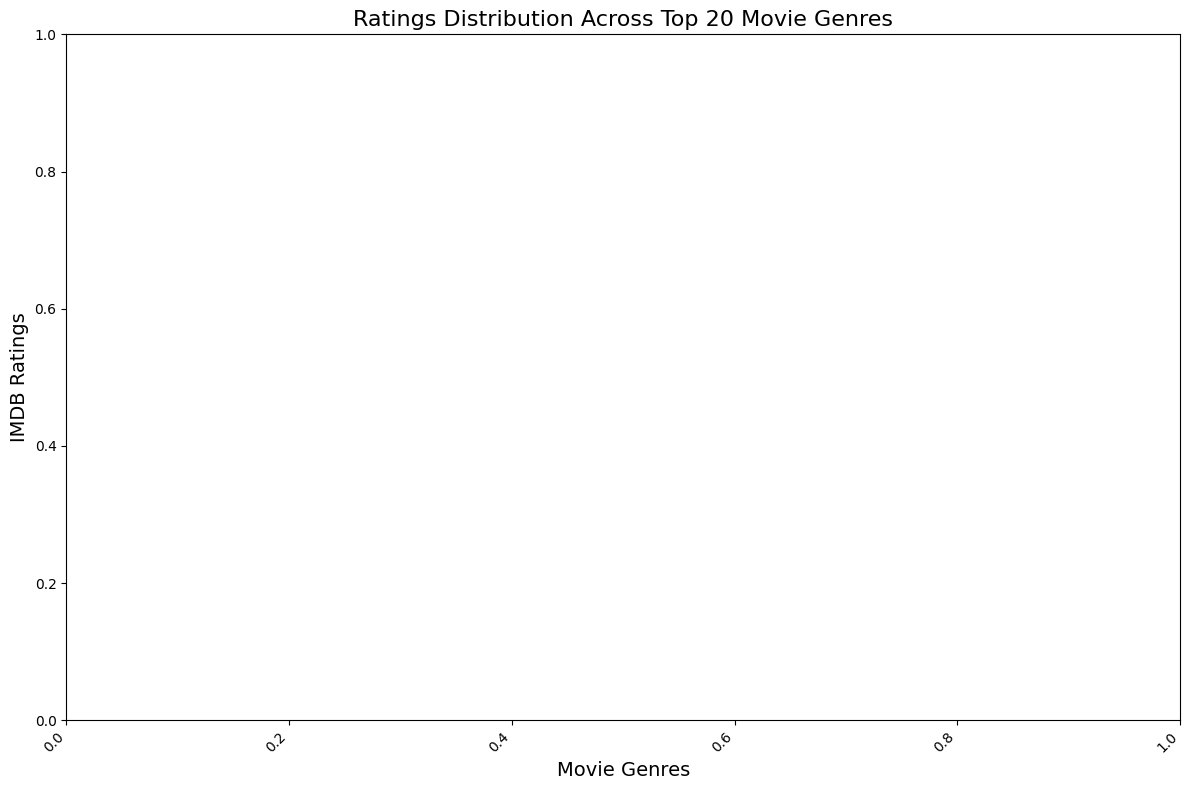

In [59]:
# Use the top 20 genres for the plot
top_20_genres = genres_counts.index[:20]

# Filter the data for only the top 10 genres
filtered_data = features_df[features_df['Movie genres'].isin(top_20_genres)]

# Generate a palette with unique colors for the top 10 genres
palette = sns.color_palette("tab20", len(top_20_genres))

# Plot ratings distribution across the top 10 genres
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=filtered_data,
    x='Movie genres',
    y='averageRating',
    order=top_20_genres,
    palette=palette
)

# Label the plot
plt.xticks(rotation=45, ha="right")
plt.title("Ratings Distribution Across Top 20 Movie Genres", fontsize=16)
plt.xlabel("Movie Genres", fontsize=14)
plt.ylabel("IMDB Ratings", fontsize=14)
plt.tight_layout()
plt.show()

The boxplot shows the IMDb ratings distribution across the top 20 movie genres, and we can observe clear trends across genres. Most genres have median ratings between 6 and 7, suggesting that movies generally receive moderate reviews. Genres like Drama, Thriller, and Comedy show a wider spread of ratings, indicating that audience opinions on these movies vary significantly. In contrast, genres such as Horror and Fantasy tend to have lower median ratings, with a higher number of poorly rated movies. On the other hand, genres like Mystery, Science Fiction, and Crime Fiction show slightly higher median ratings and fewer very low scores. Some genres, like Romantic Drama and World Cinema, have more consistent ratings with less variation. Overall, this plot highlights how audience ratings vary across genres, with some receiving more favorable reviews and others showing a mixed reception.

## Part 6.2: Are ratings similar across movies with similar topics?
To investigate this, we apply PCA for dimensionality reduction, bringing similar topics closer together in the reduced space. Next, we analyze whether movies with similar topics have comparable ratings by visualizing their ratings.

### Part 6.2.1 PCA to group topics together

In [62]:
### A METTRE DANS HELPER:PY
def plot_3d_pca(movie_data, x_col, y_col, z_col, color_col, title):
    """ 
    Makes an interactive 3D scatter plot for PCA results grouped by topics.

    Parameters:
        movie_data (pd.DataFrame): The dataframe that has the PCA data and the grouping column.
        x_col (str): Column to use for the x-axis.
        y_col (str): Column to use for the y-axis.
        z_col (str): Column to use for the z-axis.
        color_col (str): Column to color the points by (like grouping by 'Main Topic').
        title (str): The title of the plot.

    Returns:
        plotly.graph_objs._figure.Figure: The 3D scatter plot that's created.
    """

    # Generate the color palette
    seaborn_palette = sns.color_palette(palette_name, n_colors=n_colors).as_hex() # Palette "tab20" that has 20 highly distinct colors

    # Create the 3D scatter plot
    fig = px.scatter_3d(
        movie_data,
        x=x_col,
        y=y_col,
        z=z_col,
        color=color_col,
        color_discrete_sequence=seaborn_palette,
        title=title,
        labels={x_col: 'Principal Component 1', y_col: 'Principal Component 2', z_col: 'Principal Component 3'},
        width=width,
        height=height
    )

    # Update trace to set dot sizes
    fig.update_traces(
        marker=dict(size=1), # Small dot size otherwise we can't see the interior of the structure
        selector=dict(mode='markers')
    )

    # Adjust the legend
    fig.update_layout(
        legend=dict(
            itemsizing='constant',
            tracegroupgap=0
        )
    )

    # Show the plot
    fig.show()

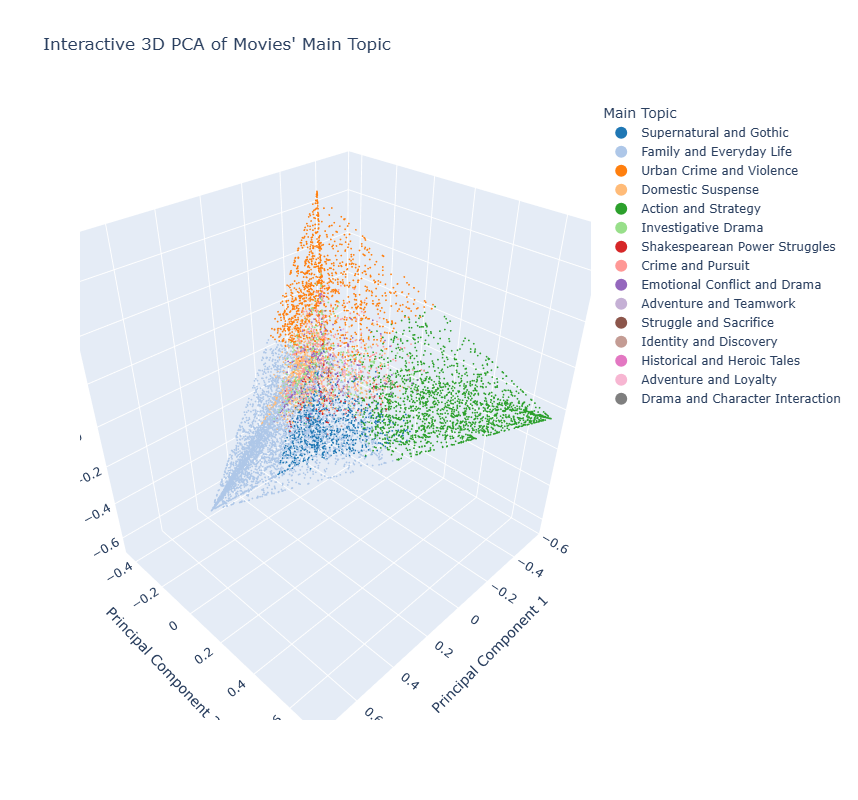

In [61]:
# Extract topic probabilities
topic_probabilities = np.array(movie_final['Topics'].tolist())

# Perform PCA to reduce from 15 to 3 dimensions only
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(topic_probabilities)

# Add reduced dimensions to the dataframe
movie_final['PC1'] = reduced_data[:, 0]
movie_final['PC2'] = reduced_data[:, 1]
movie_final['PC3'] = reduced_data[:, 2]

plot_3d_pca(movie_final, 'PC1', 'PC2', 'PC3', 'Main Topic', "Interactive 3D PCA of Movies' Main Topic")

Here the 15 dimensions of the topics were reduced to 3 using PCA. This allows to visualize the clustering of movies based on their topics, where in fact more similar movies appear close together in this 3d space. 

In [75]:
#### TP PUT IN HELPER.PY
def create_3d_scatter_with_ratings(data, x, y, z, color, title):

    """ 
    Makes and shows an interactive 3D scatter plot, using color to represent average ratings.

    Parameters:
        data (pd.DataFrame): The DataFrame with the data to plot.
        x (str): Column name for the x-axis.
        y (str): Column name for the y-axis.
        z (str): Column name for the z-axis.
        color (str): Column to use for color coding (like 'averageRating').
        title (str): The title for the plot.

    Returns:
        plotly.graph_objs._figure.Figure: The 3D scatter plot it creates.
    """

    # Create the 3D scatter plot
 
    fig = px.scatter_3d(
        data,
        x=x,
        y=y,
        z=z,
        color=color,
        title=title,
        labels={x: 'Principal Component 1', y: 'Principal Component 2', z: 'Principal Component 3'},
        width=1000,
        height=800,
        color_continuous_scale='RdYlGn',
        range_color=[4, 8]
    )

    # Update trace to adjust colorbar display
    fig.update_traces(
        marker=dict(
            size=1,
            colorbar=dict(
                title="IMDb Rating",
                tickvals=[4, 6, 8], # Customize tick values if range_color is set
                ticktext=['4', '6', '8'] # Labels for the ticks
            )
        ),
        selector=dict(mode='markers')
    )

    # Adjust legend for constant size
    fig.update_layout(
        legend=dict(
            itemsizing='constant',
            tracegroupgap=0
        )
    )

    # Show the plot
    fig.show()

### Part 6.2.2 Do similar movies with similar topics share similar ratings?

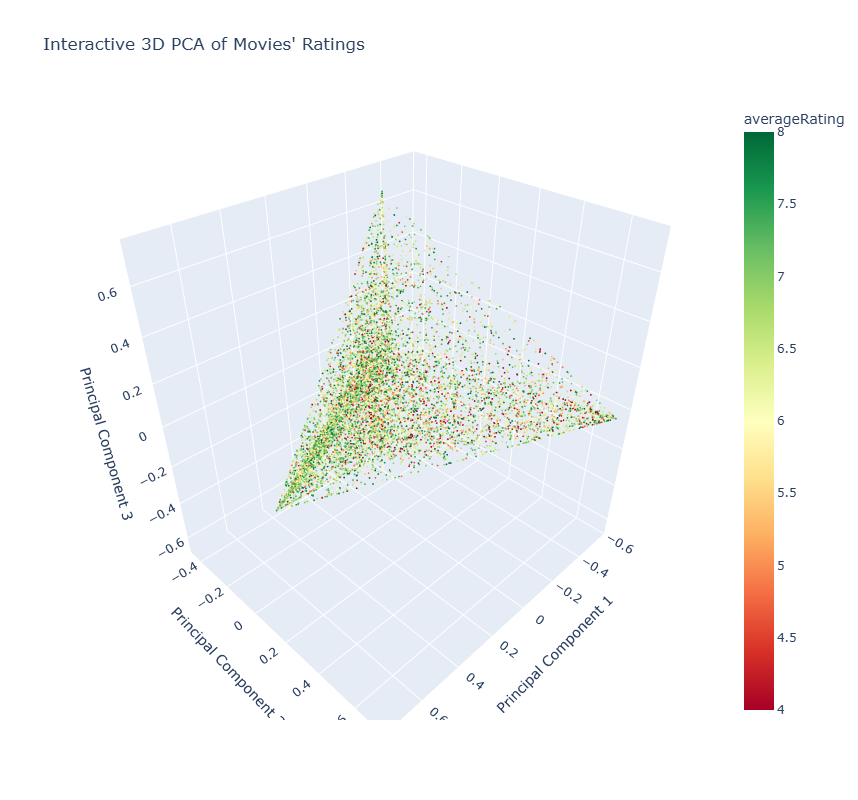

In [76]:
# Create an interactive 3D scatter plot showing the movies grouped by topics but displaying their average rating
create_3d_scatter_with_ratings(movie_final, 'PC1', 'PC2', 'PC3', 'averageRating', "Interactive 3D PCA of Movies' Ratings")


The ratings appear like salt pepper. In fact it is verified that we have our similarity measure is not up to point with movie plot only analysis. Movies that are considered as very similar by LDA, appear to have very different ratings. 

# Part 7: Additional features Analysis
## Can others features explain the ratings?

In this part, we want to determine wheter the ratings can be explained by other features. To do so, we will test three different models for linear regression. The first model will use only numerical features, the second will use only categorical features, and the third will combine both numerical and categorical features. This approach will allow us to determine which model performs best and identify which features have the most significant impact on the average ratings.

In [27]:
# Load the dataset
data = features_df.copy()

# Select relevant columns and target variable
features = ['tags', 'Movie genres', 'Movie languages', 'Movie countries', 'Movie runtime', 'IMDB Box-office', 'numVotes']
target = 'averageRating'

# Drop rows with missing values in features or target
data_cleaned = data[features + [target]].dropna()

# Define textual and numerical features
textual_features = ['tags', 'Movie genres', 'Movie languages', 'Movie countries']
numerical_features = ['Movie runtime', 'IMDB Box-office', 'numVotes']

# Extract numerical features
numerical_features_data = data_cleaned[numerical_features].fillna(0).values

# Define target variable
y = data_cleaned[target]

_Comment: In this analysis, we removed all rows with missing values, as they need to be handled for linear regression. We tested two options: keeping the 'box office' feature (which has many missing values) and removing those rows, or dropping 'box office' to keep more data. Keeping 'box office' and removing the rows gave better results, so we chose this approach._

The first model that we test is the one with numerical data.

In [28]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features_data_scaled = scaler.fit_transform(numerical_features_data)

# Train model
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(numerical_features_data_scaled, y, test_size=0.2, random_state=42)
rmse_num, r2_num, y_pred_num, model_num = train_and_evaluate(X_train_num, X_test_num, y_train_num, y_test_num)

/opt/jlab-env-3.12.5/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Next is the model containing categorical data.

In [29]:
# Apply TF-IDF vectorization to each feature independently
tfidf_vectorizers = {}
tfidf_matrices = {}

for feature in textual_features:
    vectorizer = TfidfVectorizer(max_features=500)
    tfidf_matrices[feature] = vectorizer.fit_transform(data_cleaned[feature].fillna(''))
    tfidf_vectorizers[feature] = vectorizer

# Combine all TF-IDF matrices
X_combined = hstack([tfidf_matrices[feature] for feature in textual_features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
rmse_cat, r2_cat, y_pred_cat, model_cat = train_and_evaluate(X_train, X_test, y_train, y_test)

/opt/jlab-env-3.12.5/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



And finally both combined.

In [30]:
# Combine TF-IDF features with numerical features
X_combined_reduced = hstack([X_combined, numerical_features_data_scaled])

# Train-test split
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_combined_reduced, y, test_size=0.2, random_state=42)
rmse_comb, r2_comb, y_pred_comb, model_comb = train_and_evaluate(X_train_comb, X_test_comb, y_train_comb, y_test_comb)


/opt/jlab-env-3.12.5/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Now that we have all the model we will compare them.

In [31]:
# Compare the results
comparison_results = pd.DataFrame({
    'Feature Set': ['Numerical Only', 'Categorical Only', 'Combined'],
    'RMSE': [rmse_num, rmse_cat, rmse_comb],
    'R²': [r2_num, r2_cat, r2_comb]
})

print(comparison_results)

        Feature Set      RMSE        R²
0    Numerical Only  0.923109  0.184224
1  Categorical Only  0.863545  0.286104
2          Combined  0.839682  0.325013


The results show that categorical features do a better job at predicting movie ratings, as they explain 25% of the variation in ratings (R² = 0.246998). In comparison, numerical features explain only 13% of the variation (R² = 0.130247). When we combine both types of features, the model works even better, explaining 28% of the variation (R² = 0.284440) and having the lowest error (RMSE = 0.884650). This means that using both categorical and numerical features together gives the best results.

Lets now analyze the significant features

In [32]:
results = analyze_feature_importance(textual_features=textual_features, tfidf_matrices=tfidf_matrices, tfidf_vectorizers=tfidf_vectorizers, model=model_comb, rmse=rmse_comb, r2=r2_comb, numerical_features=numerical_features,  numerical=True)

Mean Squared Error (MSE): 0.8396824138601002
R-squared (R²): 0.32501297095004167

Feature: tags
Top Positive Features:
  queer: 0.9493
  claustrophobic: 0.8059
  historical: 0.7488
  grindhouse: 0.7407
  whimsical: 0.7386
  horror: 0.6821
  atmospheric: 0.6771
  allegory: 0.6459
  gothic: 0.5820
  non: 0.5726
Top Negative Features:
  christian: -0.7565
  stupid: -0.6455
  pornographic: -0.6434
  fiction: -0.3665
  haunting: -0.2467
  adult: -0.2443
  violence: -0.2325
  reality: -0.1075
  sadist: -0.0953
  bleak: -0.0623

Feature: Movie genres
Top Positive Features:
  period: 3.8020
  concert: 3.0893
  entertainment: 2.6947
  law: 2.6687
  extreme: 2.5203
  interpersonal: 2.2099
  bengali: 2.0850
  studies: 2.0499
  pornography: 1.7935
  vampire: 1.5682
Top Negative Features:
  piece: -3.5917
  softcore: -2.4116
  porn: -2.4116
  exploitation: -2.2591
  personal: -1.6353
  hybrid: -1.6235
  nature: -1.4533
  indian: -1.3530
  interest: -1.2906
  filipino: -1.2080

Feature: Movie langua

Textual features, such as tags, genres, and languages, play a dominant role in predicting movie ratings, indicating that audience perception and content themes are more influential than numerical attributes like runtime or box office. Additionally, niche cultural elements, including specific languages and countries, strongly impact ratings, highlighting the significance of audience preferences and the value of diversity in movie content.

We also analyze the model's performance by plotting relevant metrics. 

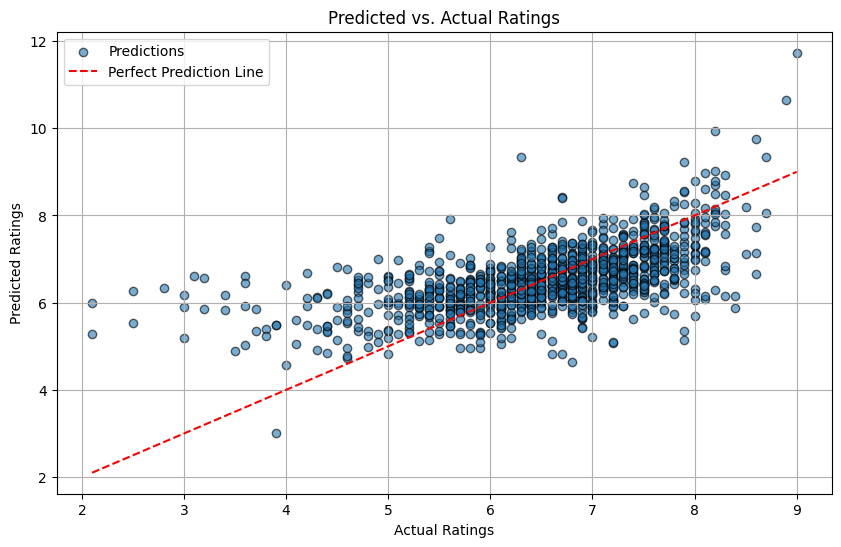

In [33]:
# Predicted vs. Actual Ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test_comb, y_pred_comb, alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([min(y_test_comb), max(y_test_comb)], [min(y_test_comb), max(y_test_comb)], 
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs. Actual Ratings')
plt.legend()
plt.grid()
plt.show()

This scatter plot shows the relationship between the model's predicted ratings and the actual ratings. The red dashed line represents perfect predictions where the predicted and actual ratings are equal. Most predictions cluster near this line, especially in the middle range of ratings (5 to 7). However, the spread increases at the extremes, indicating that the model struggles to predict very high or very low ratings accurately. This suggests that while the model performs well for average-rated movies, additional features or non-linear modeling may be needed to handle edge cases.

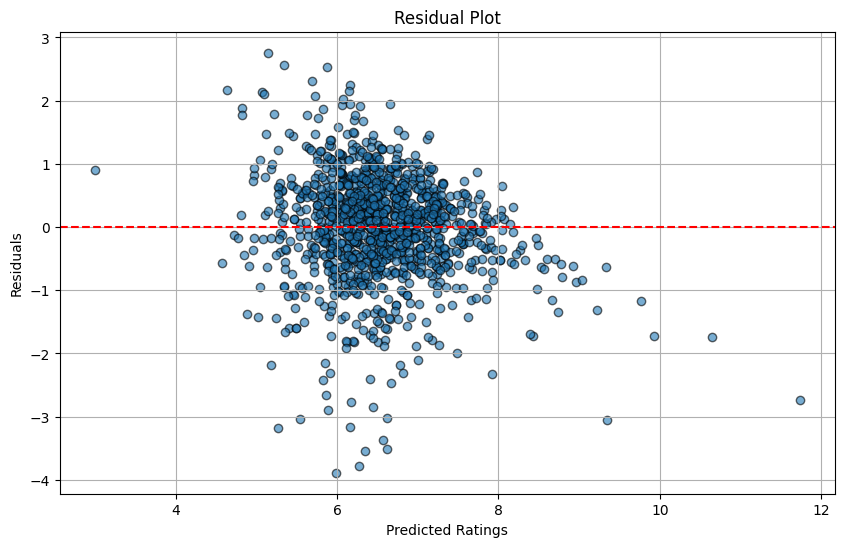

In [34]:
# Residual Plot
residuals_comb = y_test_comb - y_pred_comb
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_comb, residuals_comb, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid()
plt.show()

The residual plot help visualizes the differences between actual and predicted ratings (residuals) plotted against the predicted ratings. Ideally, residuals should be randomly scattered around the zero-error line (red dashed line). Here, the residuals are mostly centered around zero, indicating no strong systematic bias in the predictions. However, there is some spread, particularly at higher predicted ratings, suggesting the model's performance weakens for certain types of movies. 

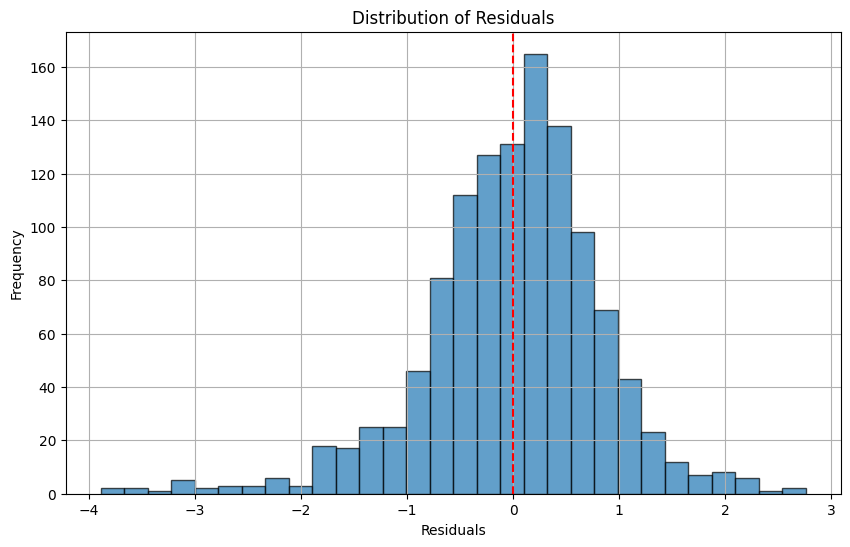

In [35]:
# Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals_comb, bins=30, alpha=0.7, edgecolor='k')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid()
plt.show()


The histogram shows the frequency distribution of residuals, with a red dashed line at zero representing perfect predictions. The residuals are symmetrically distributed and centered around zero, which is a good sign for a regression model. Most residuals fall within the range of -2 to +2, indicating that the model generally makes accurate predictions. However, the presence of outliers in the tails suggests there are a few movies for which the model struggles to predict ratings accurately. These outliers may point to missing features or complexities not captured by the model.

## Better than random model? 

Finally, we will ensure our model is better than a random one. To do so, we will randomly shuffle the x-axis many time to compare it with our model performance results. 

In [36]:
# Call the test_significance function
rmse_shuffled_list, r2_shuffled_list = test_significance(X_combined_reduced=X_combined_reduced, y=y, rmse_comb=rmse_comb, r2_comb=r2_comb,n_iterations=100)


/opt/jlab-env-3.12.5/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/opt/jlab-env-3.12.5/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/opt/jlab-env-3.12.5/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/opt/jlab-env-3.12.5/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_me

Shuffled Model Performance with Statistical Significance   Metric  Combined Model  Random Model (Mean)  \
0   RMSE        0.839682              1.08610   
1     R²        0.325013             -0.12947   

   Mean Difference (Combined - Random)        p-value  
0                             0.246418  6.278282e-126  
1                            -0.454483  1.893407e-120  


/opt/jlab-env-3.12.5/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



The combined model is significantly better than the random model in both RMSE and $R^2$, with extremely low p-values showing the robustness and consistency of this difference. This validates that the combined model effectively captures meaningful relationships in the dataset.